In [356]:
import os
import ee
import datetime
import time

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [381]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Satellites / datasets: Queried from Earth Engine
3) Years to analyze: Supplied
4) Scale: Resolution at which to perform analysis

'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/cv_hu6.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]

area = ee.Geometry.Polygon(coords)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####
area.getInfo()

{'type': 'Polygon',
 'coordinates': [[[-118.654482361682, 37.1411680413078],
   [-118.762206916723, 37.4566895272764],
   [-119.259398430534, 37.7265422810242],
   [-119.310905415871, 38.0449806440715],
   [-119.629089966419, 38.1960150761288],
   [-120.464922115121, 39.4371643262856],
   [-120.105842345887, 39.5756453135706],
   [-120.200754894698, 40.0567489586572],
   [-121.254897840979, 40.5157526850281],
   [-120.566012555589, 41.0835813539384],
   [-120.200851104073, 41.0314786331859],
   [-120.296983007049, 41.6665254634502],
   [-120.187099478053, 41.9766005848439],
   [-120.346617795513, 42.3774141613051],
   [-120.836358420795, 42.3069364176645],
   [-120.910857873804, 42.0594011597154],
   [-120.563679730593, 41.9142972870239],
   [-120.865943253041, 41.5290780147052],
   [-121.024192398628, 41.590023082319],
   [-121.118700296398, 41.4223695700792],
   [-121.280739774272, 41.6293587801745],
   [-121.589676536292, 41.6216515791448],
   [-122.502956421333, 41.3093185577546],


In [3]:
data = {}

###################
##### ET data #####
###################

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['terra'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*24 ]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['cas'] = [ee.ImageCollection('CAS/IGSNRR/PML/V2'), "ET_water", 1]

###################
##### P data ######
###################

data['trmm']  =  [ee.ImageCollection('TRMM/3B43V7'), "precipitation", 720]
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1]
data['chirps'] = [ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'), "precipitation", 1]
data['persia'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3
data['dmet'] = [ee.ImageCollection('NASA_ORNL_DAYMET_V3'), "prcp", 1]

In [4]:
def get_data(dataset, year, month):

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale().getInfo()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var] # * 1e-9 # convert m^3 to km^3
    
    return result

def wrapper(dataset):
    monthly = []

    for year in years:
        print(year)
        for month in months:
            r = get_data(dataset, year, month)
            monthly.append(r)
            
    return monthly

In [5]:
years = range(2001, 2018)
months = range(1,13)

In [6]:
# This will take a very long time to run
et_m = wrapper(data['modis'])
eto_g = wrapper(data['gmet_eto'])
etr_g = wrapper(data['gmet_etr'])
et_f = wrapper(data['fldas'])
et_t = wrapper(data['terra'])

# TODO: gldas, nldas

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [7]:
# This will take less long, but still a long time
p_p = wrapper(data['prism'])
p_c = wrapper(data['chirps'])
p_n = wrapper(data['persia'])
p_t = wrapper(data['trmm'])

# TODO: dmet

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [255]:
# Stack datasets 
p_arrs = [np.array(x) for x in [p_p, p_c, p_n, p_t]]
p_stacked = np.column_stack(p_arrs)
p = np.mean(p_stacked, axis = 1)

et_arrs = [np.array(x) for x in [et_m, eto_g, etr_g, et_f, et_t]]
et_stacked = np.column_stack(et_arrs)
et = np.mean(et_stacked, axis = 1)

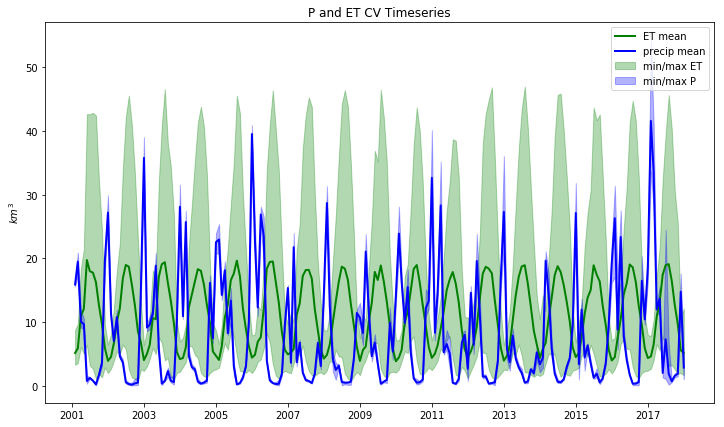

In [265]:
# Plot the means and ranges

plt.figure(figsize = (12,7))
plt.title("P and ET CV Timeseries")

plt.plot(dt_idx, et, label = "ET mean", color = "green", linewidth=2.0)
plt.fill_between(dt_idx, np.min(et_stacked, axis = 1), np.max(et_stacked, axis = 1), alpha = 0.3, color = "green", label = "min/max ET")

plt.plot(dt_idx, p, label = "precip mean", color = "blue", linewidth = 2.0)
plt.fill_between(dt_idx, np.min(p_stacked, axis = 1), np.max(p_stacked, axis = 1), alpha = 0.3, color = "blue", label = "min/max P")
plt.ylabel("$km^3$")
plt.legend()
plt.show()

In [187]:
# Read c2vsim storage data

data_dir = "../data/"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".txt")]

ds = pd.read_csv(files[0], sep='\t', header=0)
ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

# Change the ds index to be beginning of the month
# ds.index += datetime.timedelta(days = 1)

# remove local timezone
ds = ds.tz_localize(None).copy()
ds.drop(["dt", "region"],axis = 1, inplace = True)
ds['s'] = ds['s'] * 1.23348 # MAF to km^3

In [188]:
# Read USGS Q data

data_dir = "../data/"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith("Qs.csv")]

q= pd.read_csv(files[0], header=0)
q.set_index(q.columns[0], inplace = True)
q.index = pd.to_datetime(q.index)
q.index.name = "date"

# compute monthly sum and convert cms to cubic km / month
q_m = q['discharge_cms'].resample('M').sum() * 1e-9 * 86400
q = pd.DataFrame(q_m)

In [326]:
# Make a df from precip and ET RS data:
petdf = pd.DataFrame([p_p, p_c, p_n, p_t, et_m, eto_g, etr_g, et_f, et_t, list(p),list(et)]).T

start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

petdf.index = dt_idx

df_temp=pd.merge(petdf,q, how='inner', left_index=True, right_index=True)
df=pd.merge(df_temp,ds, how='inner', left_index=True, right_index=True)

df.columns = ["prism", "chirps", "persiann" ,"trmm", "modis", "gmet_eto", "gmet_etr", "fldas", "terraclimate", 'p_mean', 'et_mean', "qs", "c2v_s"]
df['ds'] = (df.p_mean - df.et_mean - df.qs)


In [333]:
# save the csv
df.to_csv("../data/all_data.csv")

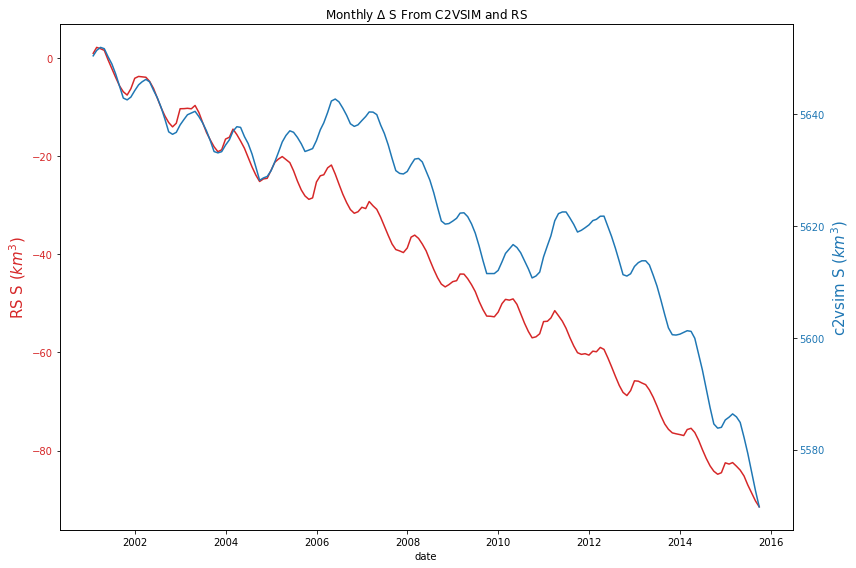

In [368]:
# Plot c2vsim DS and RS DS

fig, ax1 = plt.subplots(figsize = (12,8))
plt.title("Monthly $\Delta$ S From C2VSIM and RS")

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('RS S $(km^3)$', color=color, size = 15)
ax1.plot(df.index, np.cumsum(df.ds), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('c2vsim S ($km^3$)', color=color, size = 15)  # we already handled the x-label with ax1
ax2.plot(df.index, df.c2v_s, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [329]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['c2v_s'][-1] - hydro_year_df['c2v_s'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()
    

In [341]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=-1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})
ds_df.index = dt_idx

In [349]:
ds_df.head()

,ds,c2vds
2001-12-31,-64.813070,-6.659116
2002-12-31,-50.645958,-3.674339
2003-12-31,-55.399713,-4.698442
2004-12-31,-41.625863,4.717082
2005-12-31,-28.379299,3.973610


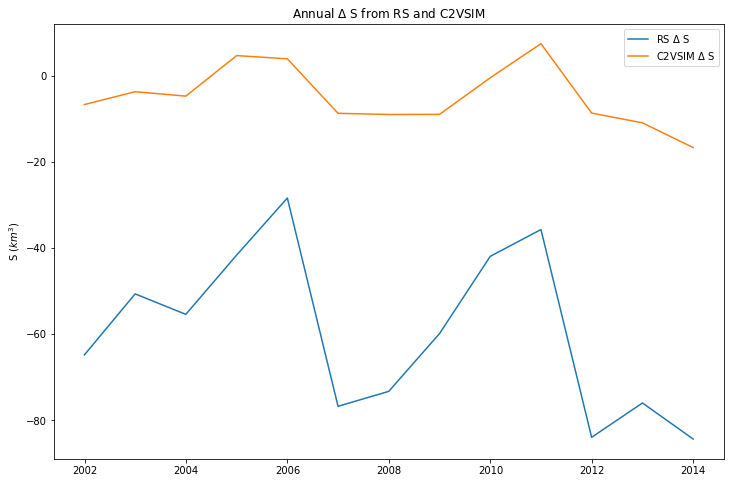

In [350]:
plt.figure(figsize = (12,8))
plt.title("Annual $\Delta$ S from RS and C2VSIM")
plt.plot(ds_df.index,ds_df.ds, label = "RS $\Delta$ S")
plt.plot(ds_df.index,ds_df.c2vds, label = "C2VSIM $\Delta$ S")
plt.ylabel("S $(km^3)$")
plt.legend()
plt.show()

# Scaling: 
## $ X_{scaled} = \frac{X_i - \mu}{\sigma_x}$

In [357]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


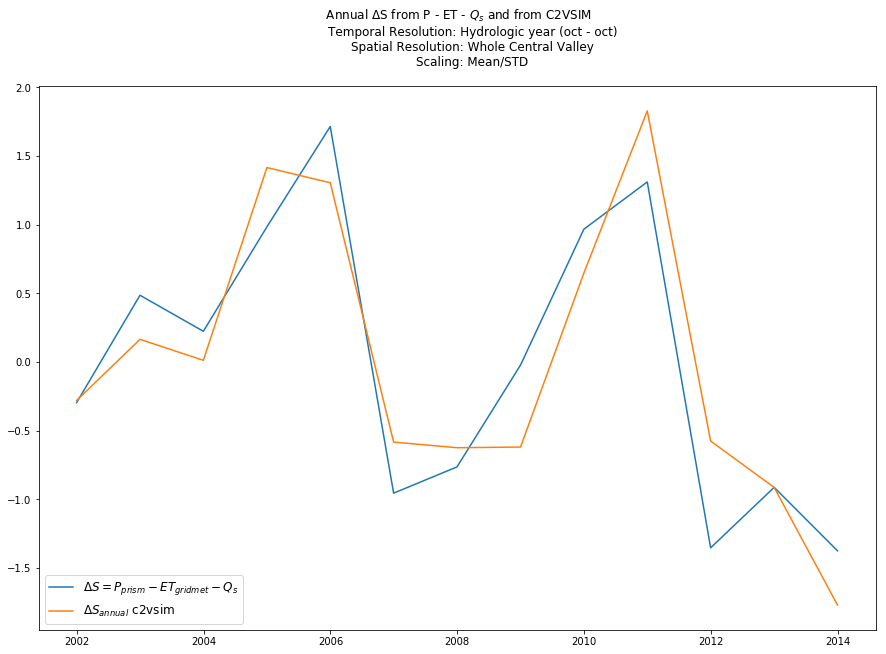

In [360]:
plt.figure(figsize=(15,10))

plt.title(
    """ Annual $\Delta$S from P - ET - $Q_s$ and from C2VSIM
        Temporal Resolution: Hydrologic year (oct - oct)
        Spatial Resolution: Whole Central Valley
        Scaling: Mean/STD
    """)

plt.plot(dt_idx, scaled[0], label = "$\Delta S = P_{prism} - ET_{gridmet} - Q_{s}$")
plt.plot(dt_idx, scaled[1], label = "$\Delta S_{annual}$ c2vsim")

# plt.plot(df.index, scaled[2], label = "$\Delta S_{monthly}$ c2vsim")

# plt.savefig("../figs/hydro_year_balance.png")

plt.legend(loc="lower left", fontsize = 'large')

plt.show()

In [ ]:
# Some EDA

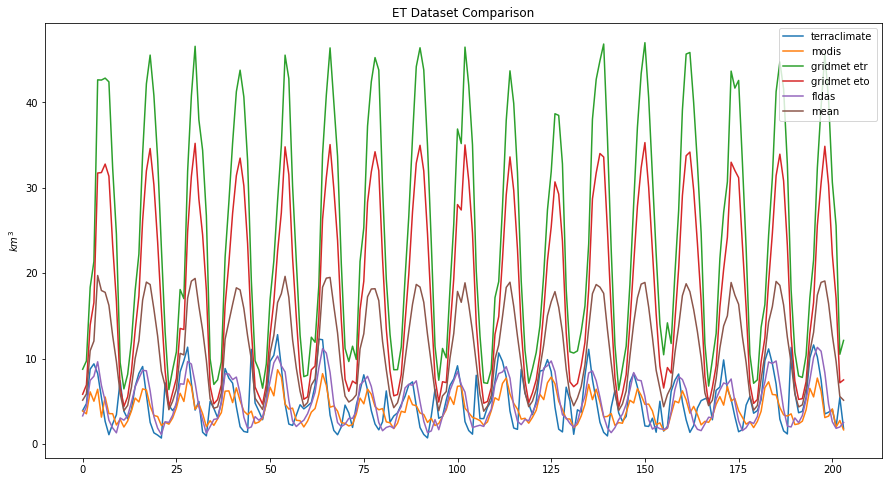

In [366]:
# ET Datasets

plt.figure(figsize = (15,8))
plt.title("ET Dataset Comparison")
plt.plot(et_t, label = 'terraclimate')
plt.plot(et_m, label = "modis")
plt.plot(etr_g, label = 'gridmet etr')
plt.plot(eto_g, label = 'gridmet eto')
plt.plot(et_f, label = 'fldas')
plt.plot(et, label = 'mean')
plt.ylabel("$km^3$")
plt.legend()
plt.show()

In [ ]:
# TODO: 
'''
Do some WBs
Take means and do the wb

do TC
Send forrest email

Change discharge station to the other one? 

Station ID: 10260776

'''

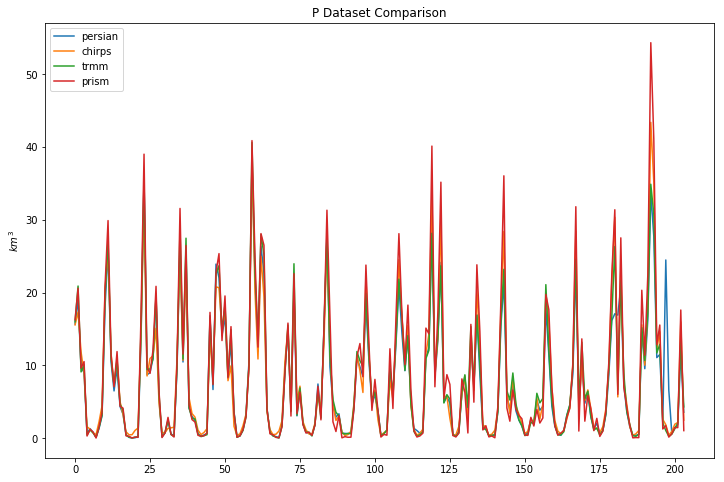

In [378]:
# P datasets

plt.figure(figsize = (12,8))
plt.title("P Dataset Comparison")
plt.plot(p_n, label = 'persian')
plt.plot(p_c, label = "chirps")
plt.plot(p_t, label = 'trmm')
plt.plot(p_p, label = 'prism')
plt.ylabel("$km^3$")
plt.legend()
plt.show()

In [423]:
# Read in the storage CSVs from the data folder

# find files
data_dir = "../data"
ds_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "storage" in x][0]
ds = pd.read_csv(ds_file, sep='\t', header=0)

q_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "Qs" in x][0]
q = pd.read_csv(q_file)

ds.set_index(ds['dt'], inplace = True)
q.set_index(q.columns[0], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)
q.index = pd.to_datetime(q.index)

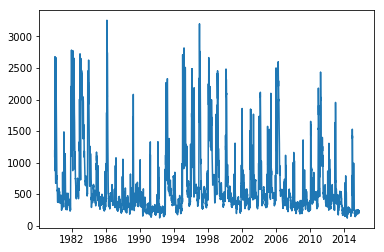

In [430]:
plt.plot(q)

In [326]:
modis_et = []

for year in years:
    print(year)
    for month in months:
        r = get_data(data['modis'], year, month)
        modis_et.append(r)
        print(r)

2000


EEException: Image.projection: Can't get band number 0. Image has no bands.

In [331]:
dataset = data['modis']
year = 2008
month = 
col = dataset[0]
var = dataset[1]
scaling_factor = dataset[2]

t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
t.getInfo()

{'type': 'Image', 'bands': []}

In [237]:
t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area)
asdf = t.getRegion(geometry = area,  scale = scale)
# t2 = asdf.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor) 
df = df_from_ee_object(asdf.getInfo())

In [238]:
arr = array_from_df(df, var)

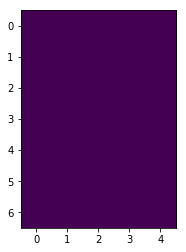

In [239]:
plt.imshow(arr)

In [240]:
scale

111319.49079327357

In [124]:
def main(col, year, month, var, resolution, scaling_factor):
    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor) # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor
    t3 = t2.reduceRegion(ee.Reducer.sum(), area, resolution) 
    info = t3.getInfo()
    return info[var]


In [125]:
def wrapper(dataset):

    results = []

    for year in years:
        print(year)
        year_res = []
        results.append(year_res)
        for month in months:
            out = main(dataset[0], year, month, dataset[1], resolution, dataset[2])
            year_res.append(out)
            time.sleep(10)
    
    unpacked = [item for sublist in results for item in sublist]
    
    return unpacked
            

In [136]:
et_modis = wrapper(data['modis'])

2001
2002
2003


EEException: Earth Engine memory capacity exceeded.

In [ ]:
prism =  wrapper(data['prism'])

In [ ]:
# np.savetxt("modis_et_km3.txt", out_data)

In [ ]:
terra =  wrapper(data['terra'])

In [ ]:
chirps = wrapper(data['chirps'])

In [105]:
et = np.array(terra)*0.1

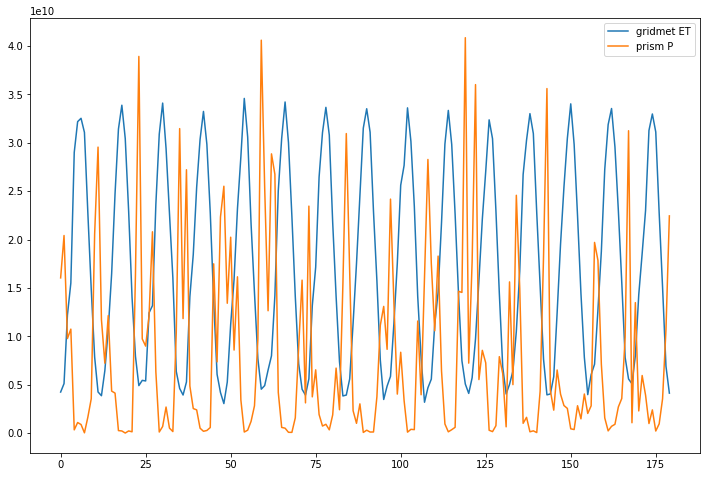

In [127]:
plt.figure(figsize=(12,8))
plt.plot(np.array(et), label = "gridmet ET")
plt.plot(np.array(prism), label = "prism P")
plt.legend()

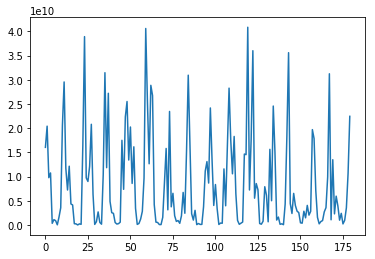

In [145]:
plt.plot(prism)

In [137]:
ds = (np.array(prism) - np.array(et))

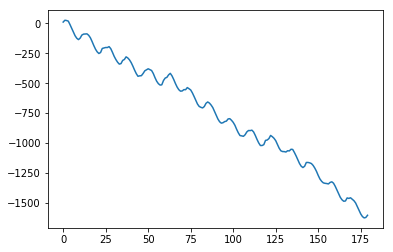

In [143]:
plt.plot(np.cumsum(ds)*1e-9)

In [61]:
# Study Area
cv = gp.read_file("../shape/cv_hu6.shp")
lls = cv.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]



# Set Params
area = ee.Geometry.Polygon(coords)
col = ee.ImageCollection('OREGONSTATE/PRISM/AN81m')
var = "ppt"
scale = 4000
year = 2012

etcol = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
etvar = "aet"

# etcol = ee.ImageCollection('MODIS/006/MOD16A2')
# etvar = "ET"

# etcol = ee.ImageCollection('MODIS/006/MOD16A2')
# etvar = "ET"

In [62]:
def asdf(col, year, month, var, resolution):
    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).filterBounds(area).select(var).sum()
    out = t.multiply(1e-3).multiply(ee.Image.pixelArea())
    asdf = out.reduceRegion(ee.Reducer.sum(), area, resolution)
    info = asdf.getInfo()
    return info[var]


In [63]:
p_sums = []
et_sums = []
months = range(1,13)

for i in months:
    print(i)
    p_sums.append(asdf(col, 2015, i, var, 10000))
    et_sums.append(asdf(etcol, 2015, i, etvar, 10000))

1
2
3
4
5
6
7
8
9
10
11
12


54.911122292711646
48.21374336224787


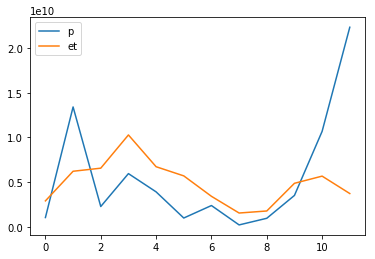

In [64]:
plt.plot(p_sums, label  = "p")
plt.plot([x*0.1 for x in et_sums], label = "et")
plt.legend()
print(np.sum(np.array(p_sums)) * 0.000810714 * 1e-6) # cubic m to MAF 
print(np.sum(np.array(et_sums)) * 0.000810714 * 1e-6 * 0.1) # cubic m to MAF 

In [ ]:
# 2015 AET 

54.911122292711646
172.85413322352363


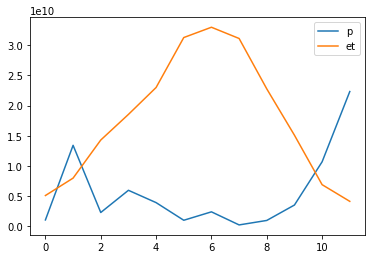

In [60]:
plt.plot(p_sums, label  = "p")
plt.plot([x*0.1 for x in et_sums], label = "et")
plt.legend()
print(np.sum(np.array(p_sums)) * 0.000810714 * 1e-6) # cubic m to MAF 
print(np.sum(np.array(et_sums)) * 0.000810714 * 1e-6 * 0.1) # cubic m to MAF 

66.8441148224882
51.54261143784149


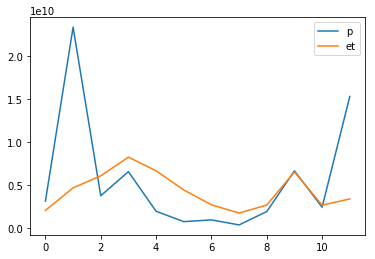

In [54]:
plt.plot(p_sums, label  = "p")
plt.plot([x*0.1 for x in et_sums], label = "et")
plt.legend()
print(np.sum(np.array(p_sums)) * 0.000810714 * 1e-6 * 1.23348) # cubic m to MAF to km^3
print(np.sum(np.array(et_sums)) * 0.000810714 * 1e-6 * 0.1 * 1.23348) # cubic m to MAF to km^3 

In [231]:
def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable):
#     df = df[df.id == str(month)] 
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr